What are we going to do?\
We need to load the chosen/best models for all objects.\
We need to load the test samples for the objects.
we need to run all samples under each model and obtain the error estimation.\
This can be done with different time predictions (starting with 3/2/1 last seconds)\
After we have all error estimations - classify each sample\
evaluate accuracy etc. vs labels.

###Imports

In [ ]:
!pip install "pandas<2"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 55.4 MB/s eta 0:00:00


In [2]:
# imports

import io
import glob
import os
import sys
from datetime import datetime
from time import time
import pickle
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import copy
import json
import matplotlib.pyplot as plt
import numpy as np
# from scipy.fft import fft
import pandas as pd
import seaborn as sns
import random
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from scipy.stats import pearsonr

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score

# torch
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential
from torch.nn import Sigmoid,ReLU
from torch.nn import Linear,Dropout
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor,Compose
from torch.optim import SparseAdam,Adam,Adagrad,SGD

!pip install einops
# from __future__ import annotations
from dataclasses import dataclass
from einops import rearrange, repeat, einsum

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

# prompt: Access a folder on google drive and import the data locally
from google.colab import drive
drive.mount('/content/drive/')
# helper files
sys.path.append('/content/drive/MyDrive/Final Project UAV/')
from UAV_project_preprocessing_and_visualization_helper_functions_full import *
from mamba_model import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.3 MB/s eta 0:00:00
Mounted at /content/drive/
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
cd /content/drive/MyDrive/Final Project UAV/

/content/drive/MyDrive/Final Project UAV


In [4]:
subfolders = os.listdir("track_data/")
subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

###preparing test samples

In [5]:
# Here we combine the test samples from all different objects (subfolders)
# Each sample duration is combined separately so that we can evaluate separately for each duration
# The model returns the error averaged over the predictions of the last 3 sec of the sequence
# For example - a 5 sec sample would have 2 sec of input sequence without evaluation, and the error will be averaged over the last 3.
# For example - a 30 sec sample would have 27 sec of input sequence without evaluation, and the error will be averaged over the last 3.

subfolders = ['airplane', 'uav', 'bird', 'static-object']
# subfolders = ['uav', 'bird']
skips = [15, 15, 2, 40]
# skips = [15, 2]
durations = [5, 10, 15, 20, 25, 30]
batch_size = 16

all_test_batches = {d:[] for d in durations}
all_test_labels = {d:[] for d in durations}
all_val_batches = {d:[] for d in durations}
all_val_labels = {d:[] for d in durations}
for subfolder, skip in zip(subfolders, skips):
  save_path = './Samples/mamba_samples_' + subfolder +'_skip'+ str(skip) +'_split0.2'+ '_all_samples'
  # save_path = './Samples/mamba_samples_' + subfolder +'_skip'+ str(skip) +'_split0.16'+ '_all_samples'
  with open(save_path , 'rb') as f:
    (subfolder_train_data, subfolder_val_data, subfolder_test_data) = pickle.load(f)
    for dur, (samples, samples_filenames, dt, scales) in subfolder_test_data.items():
      if len(samples) > 0:
        subfolder_batches = []
        subfolder_labels = []
        dur_vec = [dur]*len(samples)
        data = list(zip(samples, dt, scales, dur_vec))

        dl = DataLoader(data, batch_size = batch_size, shuffle = False)
        for batch in dl:
          subfolder_batches.append(batch)

        # Note that the batches are not full so the labels are added as the original number of samples and not based on the number of batches
        subfolder_labels.extend([labels_dict[subfolder]] * len(samples))
        all_test_batches[dur].extend(subfolder_batches)
        all_test_labels[dur].extend(subfolder_labels)


    for dur, (samples, samples_filenames, dt, scales) in subfolder_val_data.items():
      if len(samples) > 0:
        subfolder_batches = []
        subfolder_labels = []
        dur_vec = [dur]*len(samples)
        data = list(zip(samples, dt, scales, dur_vec))

        dl = DataLoader(data, batch_size = batch_size, shuffle = False)
        for batch in dl:
          subfolder_batches.append(batch)

        # Note that the batches are not full so the labels are added as the original number of samples and not based on the number of batches
        subfolder_labels.extend([labels_dict[subfolder]] * len(samples))
        all_val_batches[dur].extend(subfolder_batches)
        all_val_labels[dur].extend(subfolder_labels)

###Evaluation class

In [6]:
class Evaluating(object):

  def __init__(self, model, config):
    self.config = config
    self.device = config['device']
    self.model = model.to(self.device)
    # self.model_path = config['model_path']
    self.criterion = nn.MSELoss(reduction='none').to(self.device)
    self.evaluation_length = int(config['evaluation_time']/config['delta'])
    self.evaluation_durations = config['evaluation_durations']
    # self.criterion = config['criterion'](weight = config['class_weights']).to(self.device)

  def evaluate(self, dl_eval):
    self.eval_results = {d:[] for d in self.evaluation_durations}
    self.epoch_eval_loss = 0

    self.model.eval() #evaluation mode
    with torch.no_grad():
      for batch in tqdm(dl_eval, disable=True):
        self.eval_batch(batch)

  def eval_batch(self, batch):
    data, dt, scale, dur = batch
    # Send tensors to GPU
    samples = data[:,:-1,:]
    labels = data[:,1:,:]
    samples = samples.to(self.device)
    labels = labels.to(self.device)
    dt = dt[:, :-1].to(self.device)
    scale = scale.to(self.device)

    predictions = self.model(samples, dt)#.type(torch.float64)#.type(torch.DoubleTensor)

    scaled_labels = einsum(labels, 1/scale, 'b l d, b d -> b l d')
    # print(scaled_labels)
    scaled_predictions = einsum(predictions, 1/scale, 'b l d, b d -> b l d')
    # print(scaled_predictions)
    eval_loss = self.criterion(scaled_predictions, scaled_labels)
    self.eval_results[int(dur[0])].extend(list((eval_loss[:, -self.evaluation_length:, :].mean((1,2))).cpu()))

    self.epoch_eval_loss += eval_loss.mean().item()

### loading models, running and receiving error

In [7]:
field = 'Best Result @10'

In [8]:
subfolders = ['airplane', 'uav', 'bird', 'static-object']
all_results_df = pd.DataFrame()
for subfolder in subfolders:
  prefix = './Mamba Training Results/mamba_training_results_split0.2_' + subfolder
  folder_results_df = pd.DataFrame()
  for file in glob.glob(prefix + '*'):
    print(file)
    with open(file, 'rb') as f:
      folder_results_df = folder_results_df.append(pickle.load(f))
  folder_results_df['Object'] = subfolder
  # best_model_row = folder_results_df.loc[folder_results_df['Best Result @5'].idxmin()]
  # all_results_df = all_results_df.append(best_model_row)
  all_results_df = all_results_df.append(folder_results_df)
  all_results_df = all_results_df.drop_duplicates(field)
best_models = all_results_df.groupby('Object').apply(lambda x: x[x[field] == x[field].min()])
# best_models = all_results_df.loc[best_idx].reset_index()
saved_models_path = best_models[['Object', 'Model Path']].set_index('Object').to_dict()['Model Path']
# saved_models_path = all_results_df[['Object', 'Model Path']].set_index('Object').to_dict()['Model Path']

./Mamba Training Results/mamba_training_results_split0.2_airplane04_04_2024, 10:17:14
./Mamba Training Results/mamba_training_results_split0.2_airplane04_10_2024, 16:08:04
./Mamba Training Results/mamba_training_results_split0.2_airplane04_10_2024, 16:51:44
./Mamba Training Results/mamba_training_results_split0.2_uav04_04_2024, 11:45:41
./Mamba Training Results/mamba_training_results_split0.2_uav04_11_2024, 04:57:09
./Mamba Training Results/mamba_training_results_split0.2_bird04_04_2024, 07:58:22
./Mamba Training Results/mamba_training_results_split0.2_bird04_04_2024, 08:32:41
./Mamba Training Results/mamba_training_results_split0.2_static-object04_04_2024, 13:50:05
./Mamba Training Results/mamba_training_results_split0.2_static-object04_11_2024, 10:15:52


In [ ]:
all_results_df

In [9]:
best_models

,,datetime,Best Result @5,Best Result @10,Best Result @20,Learning Rate,Batch Size,Layers,d_state,Model Path,Test Files,Mamba Config,Training Config,Train Loss History,Evaluation Loss History,Eval History,Best Results,Object
Object,,,,,,,,,,,,,,,,,,
airplane,1,"04/10/2024, 16:51:44",25951,24926,25643,0.01,32,2,16,./Models/mamba_model_airplane_dm8nl2ds16dc4rs4...,[VIS_airplane_20231023-6210_20231023-162937.js...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4167401.966282895, 3774465.2976973685, 342633...","[1156171.3317307692, 1002759.4519230769, 87645...","{5: [tensor(966874.6875), tensor(850389.), ten...","{5: tensor(25951.9375), 10: tensor(24926.3535)...",airplane
bird,0,"04/04/2024, 07:58:22",2009,894,1236,0.05,32,2,16,./Models/mamba_model_bird_dm8nl2ds16dc4rs42bs3...,"[VIS_bird_20231116-20636_20231116-082324.json,...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[291574.09801136365, 255982.78941761365, 22666...","[229681.61830357142, 198624.72433035713, 17256...","{5: [tensor(206164.3125), tensor(178804.3281),...","{5: tensor(2009.7250), 10: tensor(894.1389), 1...",bird
static-object,0,"04/11/2024, 10:15:52",19819,23948,7809,0.01,32,2,16,./Models/mamba_model_static-object_dm8nl2ds16d...,[NIR_static-object_20231024-48984_20231024-234...,"{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[13983462.18939394, 12031126.984848484, 103617...","[6284997.214285715, 5050981.761904762, 4145497...","{5: [tensor(9513625.), tensor(7972746.), tenso...","{5: tensor(19819.8145), 10: tensor(23948.6816)...",static-object
uav,0,"04/11/2024, 04:57:09",3040,1931,3640,0.01,32,2,16,./Models/mamba_model_uav_dm8nl2ds16dc4rs42bs32...,"[VIS_uav_20231027-10807_20231027-113911.json, ...","{'d_model': 8, 'n_layer': 2, 'd_state': 16, 'e...","{'batch_size': 32, 'optimizer_type': <class 't...","[4395118.354166667, 3713927.0520833335, 311597...","[4172366.2959558824, 3538994.6727941176, 29729...","{5: [tensor(4344296.), tensor(3685911.), tenso...","{5: tensor(3040.7278), 10: tensor(1931.6913), ...",uav


In [11]:
for line in all_results_df['Model Path']:
  print(line)

./Models/mamba_model_airplane_dm8nl2ds16dc4rs42bs32opAdamlr0.05r104_04_2024, 09:56:52
./Models/mamba_model_airplane_dm8nl1ds16dc4rs42bs64opAdamlr0.01r104_04_2024, 10:17:14
./Models/mamba_model_uav_dm8nl1ds16dc4rs42bs32opAdamlr0.01r104_04_2024, 11:45:41
./Models/mamba_model_bird_dm8nl2ds16dc4rs42bs32opAdamlr0.05r104_04_2024, 07:58:22
./Models/mamba_model_bird_dm8nl2ds16dc4rs42bs32opAdamlr0.01r104_04_2024, 08:32:41
./Models/mamba_model_static-object_dm8nl1ds16dc4rs42bs32opAdamlr0.01r104_04_2024, 13:50:05


In [12]:
saved_models_path

{'airplane': './Models/mamba_model_airplane_dm8nl1ds16dc4rs42bs64opAdamlr0.01r104_04_2024, 10:17:14',
 'bird': './Models/mamba_model_bird_dm8nl2ds16dc4rs42bs32opAdamlr0.05r104_04_2024, 07:58:22',
 'static-object': './Models/mamba_model_static-object_dm8nl1ds16dc4rs42bs32opAdamlr0.01r104_04_2024, 13:50:05',
 'uav': './Models/mamba_model_uav_dm8nl1ds16dc4rs42bs32opAdamlr0.01r104_04_2024, 11:45:41'}

In [21]:
# saved_models_path['uav'] = './Models/mamba_model_uav_dm8nl1ds16dc4rs42bs16opAdamlr0.1r104_03_2024, 08:43:05'

In [10]:
durations =[5, 10, 15, 20, 25, 30]
evaluation_config = {'batch_size': 32, 'device' : device, 'evaluation_time': 3, 'delta': 0.04, 'evaluation_durations': durations} #can tale delta from sample config
flying_objects = ['airplane', 'uav', 'bird', 'static-object']
# flying_objects = ['uav', 'bird']
# saved_models_path = {'uav':'mamba_model_uav_dm8nl1ds16dc4rs42bs32lr0.1r3', 'bird': 'mamba_model_bird_dm8nl1ds16dc4rs42bs32lr0.1r3'}
evaluation_results = {}

for f_object in flying_objects:
  best_object_row = best_models.loc[best_models['Object'] == f_object]
  model_path = best_object_row['Model Path'].values[0]
  state = torch.load(model_path, map_location=torch.device('cpu'))

  mamba_config = best_object_row['Mamba Config'].values[0]
  # mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  mamba_model.load_state_dict(state['state_dict'])

  evaluating_mamba = Evaluating(mamba_model, evaluation_config)
  all = []
  for dur in durations:
    all.extend(all_test_batches[dur])

  evaluating_mamba.evaluate(all)
  evaluation_results[f_object] = evaluating_mamba.eval_results

In [12]:
durations =[5, 10, 15, 20, 25, 30]
evaluation_config = {'batch_size': 32, 'device' : device, 'evaluation_time': 4, 'delta': 0.04, 'evaluation_durations': durations} #can tale delta from sample config
flying_objects = ['airplane', 'uav', 'bird', 'static-object']
# flying_objects = ['uav', 'bird']
# saved_models_path = {'uav':'mamba_model_uav_dm8nl1ds16dc4rs42bs32lr0.1r3', 'bird': 'mamba_model_bird_dm8nl1ds16dc4rs42bs32lr0.1r3'}
evaluation_results = {}

for f_object in flying_objects:
  best_object_row = best_models.loc[best_models['Object'] == f_object]
  model_path = best_object_row['Model Path'].values[0]
  state = torch.load(model_path, map_location=torch.device('cpu'))

  mamba_config = best_object_row['Mamba Config'].values[0]
  # mamba_config = {'d_model' : 8, 'n_layer': 1, 'd_state' : 16, 'expand' : 2, 'd_conv' : 4, 'model_random_state' : 42}
  args = ModelArgs(mamba_config['d_model'], mamba_config['n_layer'], mamba_config['d_state'], mamba_config['expand'], mamba_config['d_conv'])
  mamba_model = Mamba(args)

  mamba_model.load_state_dict(state['state_dict'])

  evaluating_mamba = Evaluating(mamba_model, evaluation_config)
  all = []
  for dur in durations:
    all.extend(all_test_batches[dur])

  evaluating_mamba.evaluate(all)
  evaluation_results[f_object] = evaluating_mamba.eval_results

In [ ]:
# evaluation_results['bird'].keys()

dict_keys([5, 10, 15, 20, 25, 30])

In [ ]:
# evaluation_results['bird'][30]

In [ ]:
# evaluation_results

###Classification evaluation

In [11]:
subf_dict = {i:subfolders[i] for i in range(len(subfolders))}
labels_dict = {subfolders[i]:i for i in range(len(subfolders))}

After static improvement

               precision    recall  f1-score   support

     airplane       0.45      0.51      0.48        59
          uav       0.56      1.00      0.72        83
         bird       1.00      0.22      0.37        58
static-object       0.76      0.56      0.65       103

     accuracy                           0.61       303
    macro avg       0.69      0.57      0.55       303
 weighted avg       0.69      0.61      0.58       303



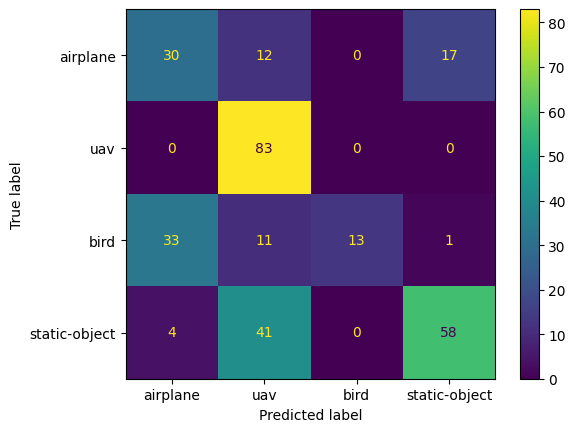

               precision    recall  f1-score   support

     airplane       0.49      0.60      0.54        52
          uav       0.57      1.00      0.73        81
         bird       1.00      0.21      0.35        43
static-object       0.81      0.51      0.63       101

     accuracy                           0.62       277
    macro avg       0.72      0.58      0.56       277
 weighted avg       0.71      0.62      0.60       277



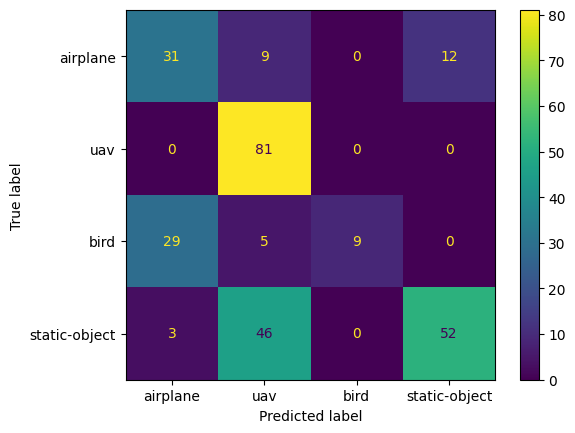

               precision    recall  f1-score   support

     airplane       0.44      0.60      0.51        40
          uav       0.59      1.00      0.74        78
         bird       1.00      0.06      0.12        31
static-object       0.86      0.52      0.65        97

     accuracy                           0.63       246
    macro avg       0.72      0.54      0.50       246
 weighted avg       0.73      0.63      0.59       246



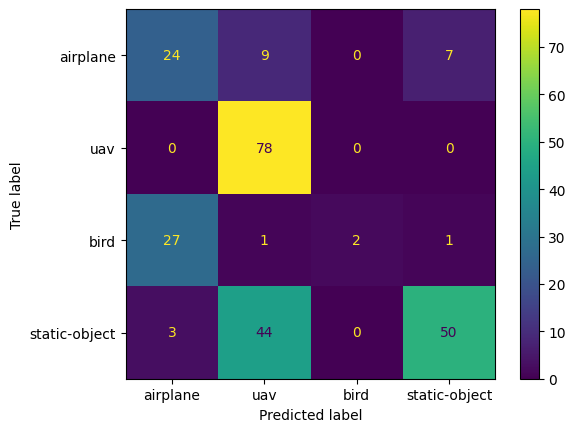

               precision    recall  f1-score   support

     airplane       0.40      0.50      0.44        34
          uav       0.60      1.00      0.75        73
         bird       0.00      0.00      0.00        23
static-object       0.89      0.56      0.69        91

     accuracy                           0.64       221
    macro avg       0.47      0.52      0.47       221
 weighted avg       0.63      0.64      0.60       221



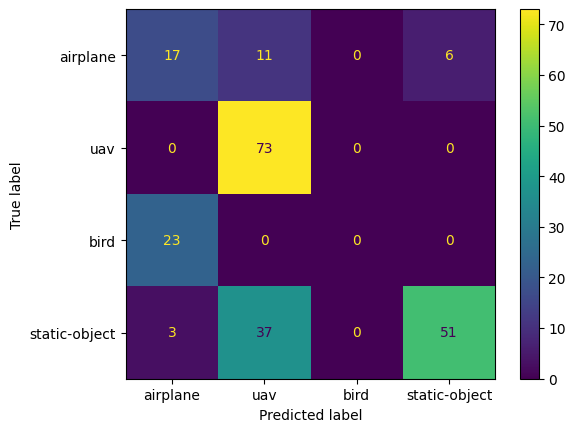

               precision    recall  f1-score   support

     airplane       0.41      0.52      0.45        29
          uav       0.62      1.00      0.76        71
         bird       0.00      0.00      0.00        19
static-object       0.90      0.54      0.68        83

     accuracy                           0.65       202
    macro avg       0.48      0.51      0.47       202
 weighted avg       0.65      0.65      0.61       202



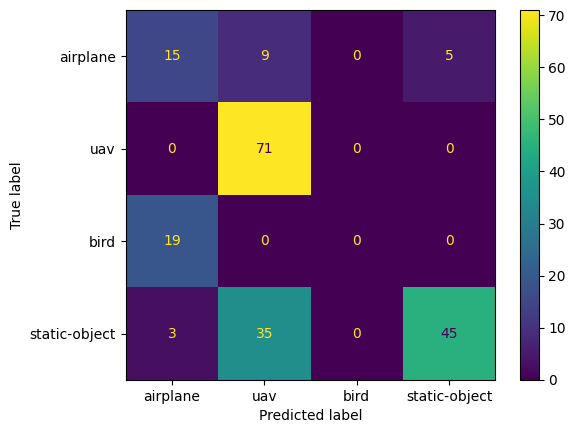

               precision    recall  f1-score   support

     airplane       0.38      0.46      0.42        24
          uav       0.59      1.00      0.74        68
         bird       0.00      0.00      0.00        15
static-object       0.90      0.47      0.62        77

     accuracy                           0.62       184
    macro avg       0.47      0.48      0.44       184
 weighted avg       0.64      0.62      0.59       184



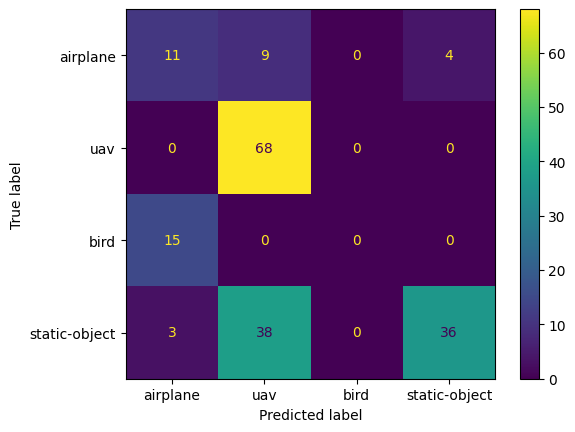

In [12]:
all_reports = {d:[] for d in durations}
for dur in durations:
  dur_labels = all_test_labels[dur]
  errors = torch.full((len(subf_dict.keys()), len(dur_labels)), torch.inf)
  for f_object, eval_results in evaluation_results.items():
    if len(eval_results[dur]) > 0:
      errors[labels_dict[f_object]] = torch.tensor(eval_results[dur])
  predicted_class = torch.argmin(errors, dim=0)
  report = classification_report(dur_labels, predicted_class, target_names=evaluation_results.keys())
  cm = confusion_matrix(dur_labels, predicted_class)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=flying_objects)
  # cm = confusion_matrix(dur_labels, predicted_class, labels=flying_objects)
  all_reports[dur] = report
  print(report)
  disp.plot()
  # disp.ax_.set_title(caption)
  plt.show()

In [33]:
subf_dict

{0: 'airplane', 1: 'uav', 2: 'bird', 3: 'static-object'}

with evaluation time 4 sec

               precision    recall  f1-score   support

     airplane       0.53      0.61      0.57        59
          uav       0.47      1.00      0.64        83
         bird       0.70      0.24      0.36        58
static-object       0.70      0.27      0.39       103

     accuracy                           0.53       303
    macro avg       0.60      0.53      0.49       303
 weighted avg       0.60      0.53      0.49       303



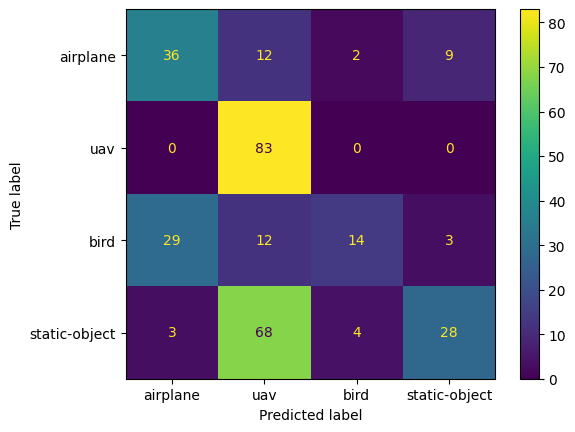

               precision    recall  f1-score   support

     airplane       0.52      0.67      0.59        52
          uav       0.47      1.00      0.64        81
         bird       0.67      0.19      0.29        43
static-object       0.70      0.19      0.30       101

     accuracy                           0.52       277
    macro avg       0.59      0.51      0.45       277
 weighted avg       0.60      0.52      0.45       277



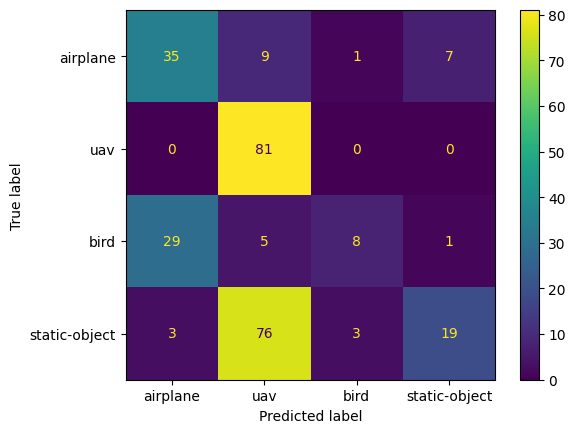

               precision    recall  f1-score   support

     airplane       0.46      0.65      0.54        40
          uav       0.50      1.00      0.66        78
         bird       0.40      0.06      0.11        31
static-object       0.81      0.23      0.35        97

     accuracy                           0.52       246
    macro avg       0.54      0.49      0.42       246
 weighted avg       0.60      0.52      0.45       246



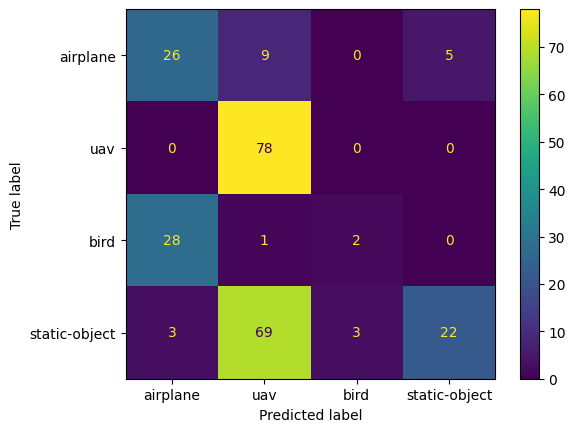

               precision    recall  f1-score   support

     airplane       0.43      0.59      0.50        34
          uav       0.50      1.00      0.67        73
         bird       0.00      0.00      0.00        23
static-object       0.85      0.24      0.38        91

     accuracy                           0.52       221
    macro avg       0.45      0.46      0.39       221
 weighted avg       0.58      0.52      0.45       221



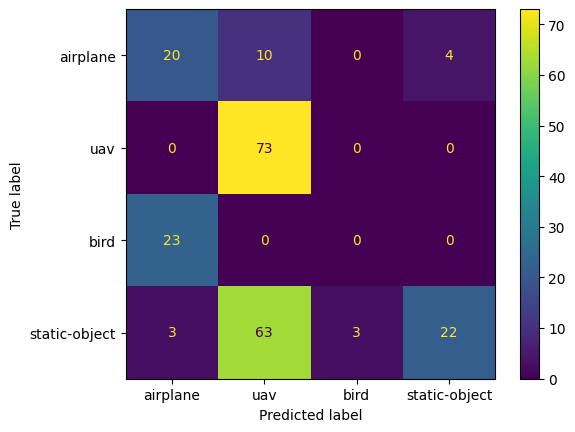

               precision    recall  f1-score   support

     airplane       0.42      0.55      0.48        29
          uav       0.52      1.00      0.69        71
         bird       0.00      0.00      0.00        19
static-object       0.85      0.27      0.40        83

     accuracy                           0.54       202
    macro avg       0.45      0.45      0.39       202
 weighted avg       0.59      0.54      0.48       202



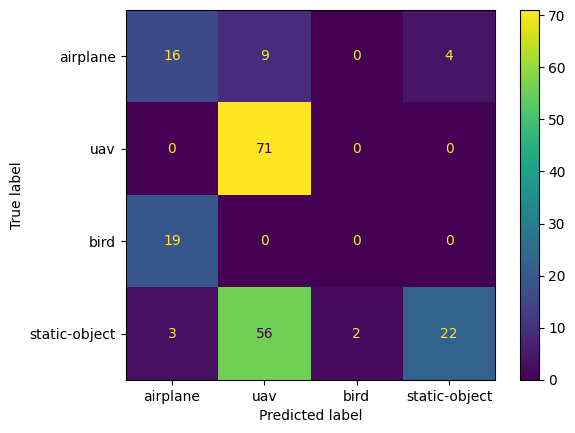

               precision    recall  f1-score   support

     airplane       0.36      0.42      0.38        24
          uav       0.53      1.00      0.69        68
         bird       0.00      0.00      0.00        15
static-object       0.85      0.29      0.43        77

     accuracy                           0.54       184
    macro avg       0.43      0.43      0.38       184
 weighted avg       0.60      0.54      0.49       184



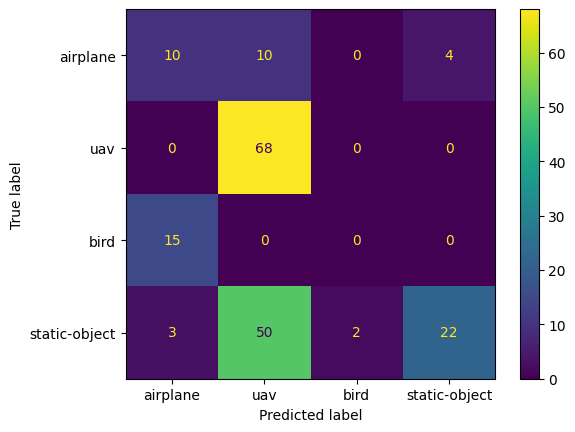

In [13]:
all_reports = {d:[] for d in durations}
for dur in durations:
  dur_labels = all_test_labels[dur]
  errors = torch.full((len(subf_dict.keys()), len(dur_labels)), torch.inf)
  for f_object, eval_results in evaluation_results.items():
    if len(eval_results[dur]) > 0:
      errors[labels_dict[f_object]] = torch.tensor(eval_results[dur])
  predicted_class = torch.argmin(errors, dim=0)
  report = classification_report(dur_labels, predicted_class, target_names=evaluation_results.keys())
  cm = confusion_matrix(dur_labels, predicted_class)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=flying_objects)
  # cm = confusion_matrix(dur_labels, predicted_class, labels=flying_objects)
  all_reports[dur] = report
  print(report)
  disp.plot()
  # disp.ax_.set_title(caption)
  plt.show()

with evaluation time 2 sec

               precision    recall  f1-score   support

     airplane       0.54      0.63      0.58        59
          uav       0.48      1.00      0.65        83
         bird       0.73      0.28      0.40        58
static-object       0.70      0.27      0.39       103

     accuracy                           0.54       303
    macro avg       0.61      0.54      0.51       303
 weighted avg       0.61      0.54      0.50       303



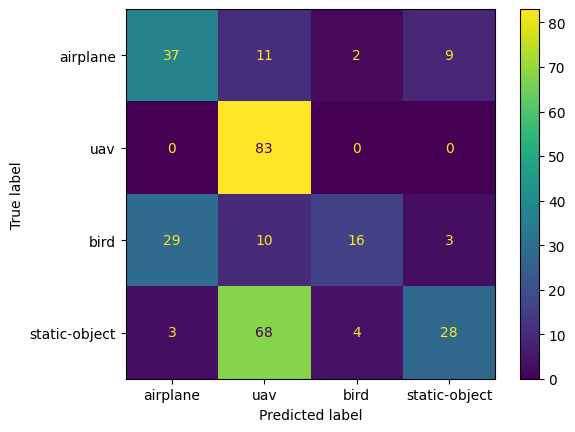

               precision    recall  f1-score   support

     airplane       0.52      0.65      0.58        52
          uav       0.49      1.00      0.66        81
         bird       0.67      0.19      0.29        43
static-object       0.73      0.24      0.36       101

     accuracy                           0.53       277
    macro avg       0.60      0.52      0.47       277
 weighted avg       0.61      0.53      0.48       277



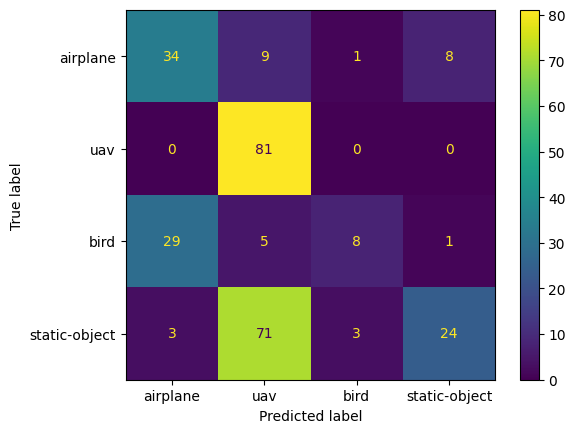

               precision    recall  f1-score   support

     airplane       0.46      0.65      0.54        40
          uav       0.50      1.00      0.66        78
         bird       0.40      0.06      0.11        31
static-object       0.81      0.23      0.35        97

     accuracy                           0.52       246
    macro avg       0.54      0.49      0.42       246
 weighted avg       0.60      0.52      0.45       246



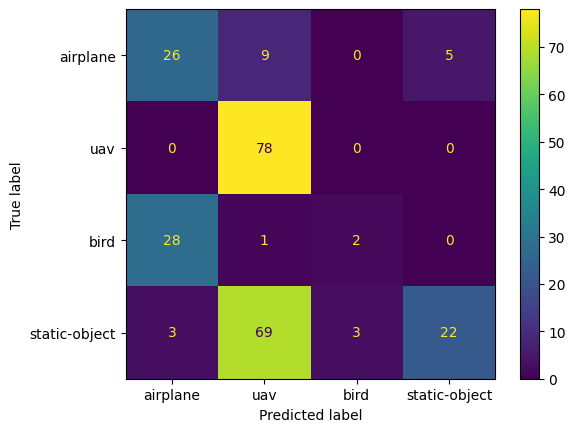

               precision    recall  f1-score   support

     airplane       0.42      0.56      0.48        34
          uav       0.50      1.00      0.67        73
         bird       0.00      0.00      0.00        23
static-object       0.81      0.24      0.37        91

     accuracy                           0.52       221
    macro avg       0.43      0.45      0.38       221
 weighted avg       0.57      0.52      0.45       221



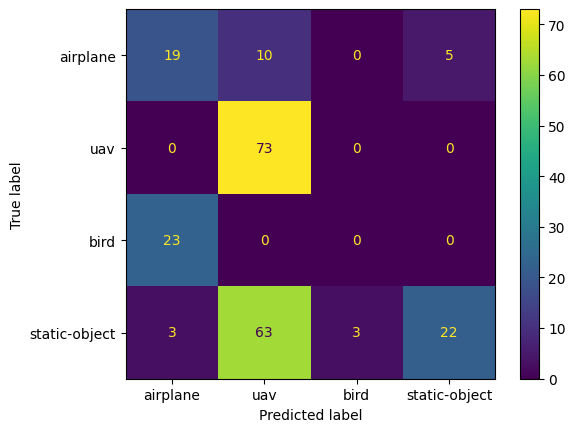

               precision    recall  f1-score   support

     airplane       0.41      0.52      0.45        29
          uav       0.51      1.00      0.68        71
         bird       0.00      0.00      0.00        19
static-object       0.80      0.24      0.37        83

     accuracy                           0.52       202
    macro avg       0.43      0.44      0.38       202
 weighted avg       0.57      0.52      0.46       202



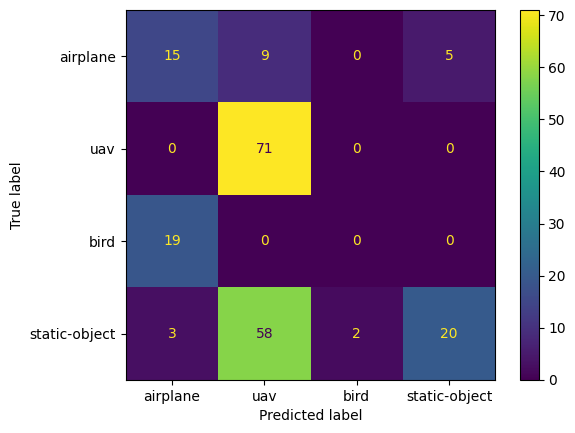

               precision    recall  f1-score   support

     airplane       0.38      0.46      0.42        24
          uav       0.53      1.00      0.69        68
         bird       0.00      0.00      0.00        15
static-object       0.83      0.26      0.40        77

     accuracy                           0.54       184
    macro avg       0.43      0.43      0.38       184
 weighted avg       0.59      0.54      0.48       184



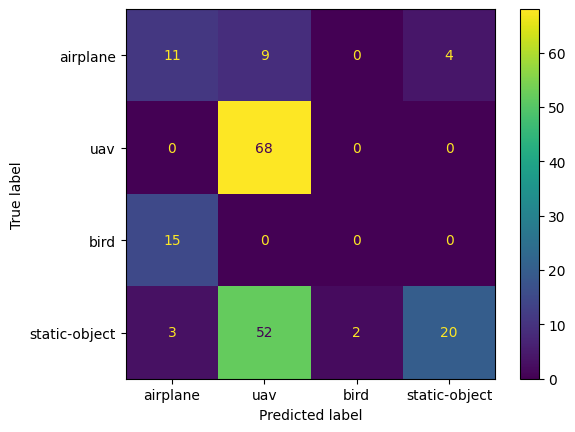

In [11]:
all_reports = {d:[] for d in durations}
for dur in durations:
  dur_labels = all_test_labels[dur]
  errors = torch.full((len(subf_dict.keys()), len(dur_labels)), torch.inf)
  for f_object, eval_results in evaluation_results.items():
    if len(eval_results[dur]) > 0:
      errors[labels_dict[f_object]] = torch.tensor(eval_results[dur])
  predicted_class = torch.argmin(errors, dim=0)
  report = classification_report(dur_labels, predicted_class, target_names=evaluation_results.keys())
  cm = confusion_matrix(dur_labels, predicted_class)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=flying_objects)
  # cm = confusion_matrix(dur_labels, predicted_class, labels=flying_objects)
  all_reports[dur] = report
  print(report)
  disp.plot()
  # disp.ax_.set_title(caption)
  plt.show()

In [ ]:
predicted_class

with evaluation time 3 sec

               precision    recall  f1-score   support

     airplane       0.52      0.61      0.56        59
          uav       0.48      1.00      0.65        83
         bird       0.70      0.24      0.36        58
static-object       0.70      0.27      0.39       103

     accuracy                           0.53       303
    macro avg       0.60      0.53      0.49       303
 weighted avg       0.60      0.53      0.49       303



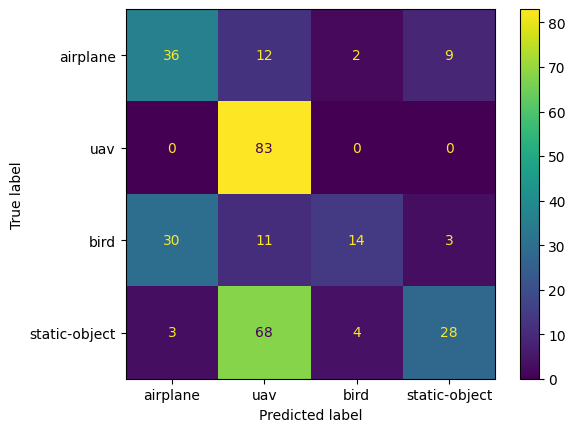

               precision    recall  f1-score   support

     airplane       0.52      0.65      0.58        52
          uav       0.48      1.00      0.65        81
         bird       0.69      0.21      0.32        43
static-object       0.73      0.22      0.34       101

     accuracy                           0.53       277
    macro avg       0.61      0.52      0.47       277
 weighted avg       0.61      0.53      0.47       277



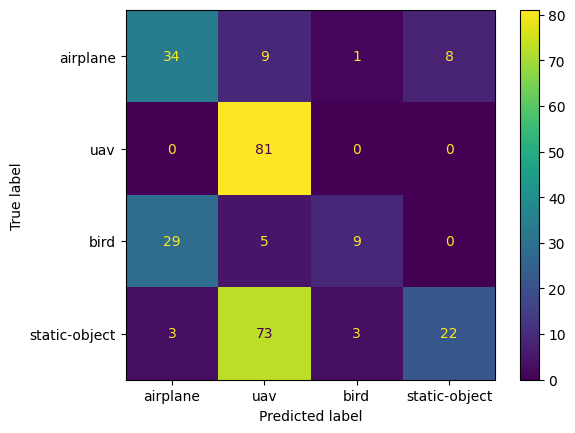

               precision    recall  f1-score   support

     airplane       0.46      0.65      0.54        40
          uav       0.50      1.00      0.67        78
         bird       0.40      0.06      0.11        31
static-object       0.82      0.24      0.37        97

     accuracy                           0.52       246
    macro avg       0.54      0.49      0.42       246
 weighted avg       0.61      0.52      0.46       246



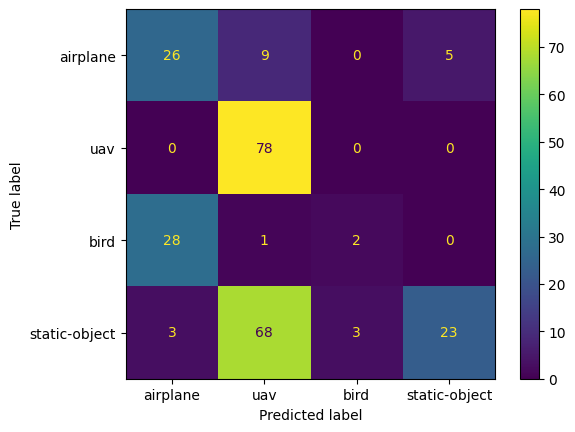

               precision    recall  f1-score   support

     airplane       0.42      0.56      0.48        34
          uav       0.49      1.00      0.66        73
         bird       0.00      0.00      0.00        23
static-object       0.84      0.23      0.36        91

     accuracy                           0.51       221
    macro avg       0.44      0.45      0.38       221
 weighted avg       0.57      0.51      0.44       221



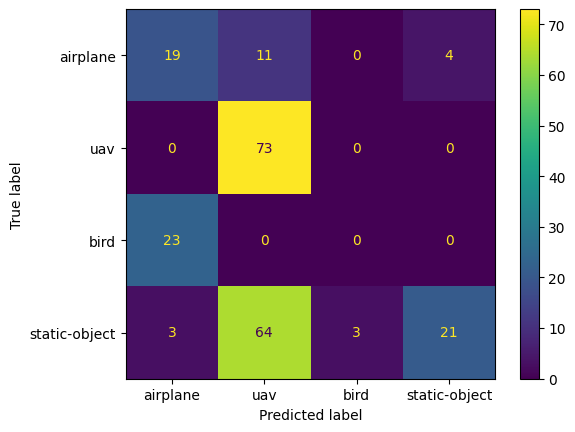

               precision    recall  f1-score   support

     airplane       0.41      0.52      0.45        29
          uav       0.52      1.00      0.68        71
         bird       0.00      0.00      0.00        19
static-object       0.81      0.25      0.39        83

     accuracy                           0.53       202
    macro avg       0.43      0.44      0.38       202
 weighted avg       0.57      0.53      0.46       202



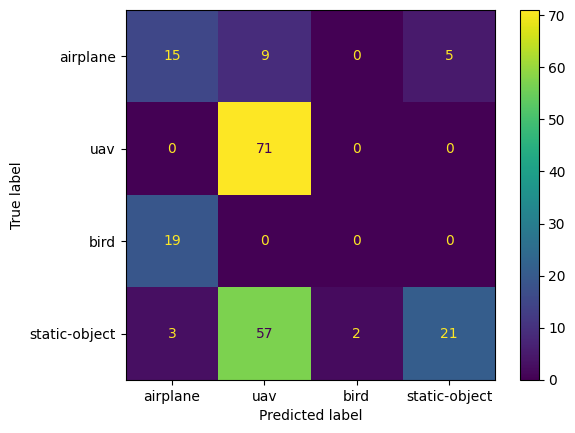

               precision    recall  f1-score   support

     airplane       0.38      0.46      0.42        24
          uav       0.54      1.00      0.70        68
         bird       0.00      0.00      0.00        15
static-object       0.85      0.29      0.43        77

     accuracy                           0.55       184
    macro avg       0.44      0.44      0.38       184
 weighted avg       0.60      0.55      0.49       184



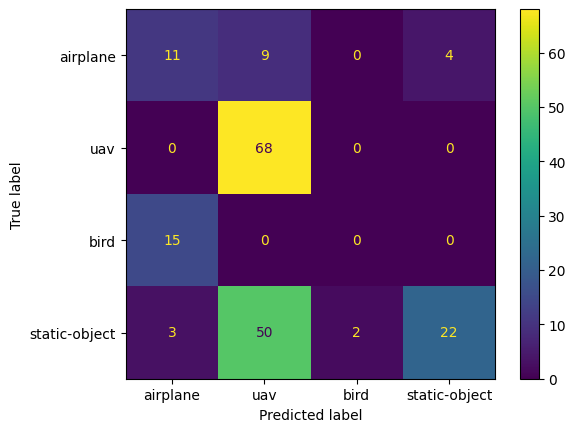

In [13]:
# def classify(evaluation_results, all_test_labels):

all_reports = {d:[] for d in durations}
for dur in durations:
  dur_labels = all_test_labels[dur]
  errors = torch.full((len(subf_dict.keys()), len(dur_labels)), torch.inf)
  for f_object, eval_results in evaluation_results.items():
    if len(eval_results[dur]) > 0:
      errors[labels_dict[f_object]] = torch.tensor(eval_results[dur])
  predicted_class = torch.argmin(errors, dim=0)
  report = classification_report(dur_labels, predicted_class, target_names=evaluation_results.keys())
  cm = confusion_matrix(dur_labels, predicted_class)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=flying_objects)
  # cm = confusion_matrix(dur_labels, predicted_class, labels=flying_objects)
  all_reports[dur] = report
  print(report)
  disp.plot()
  # disp.ax_.set_title(caption)
  plt.show()

  # return all_reports

In [ ]:
predicted_class

In [14]:
# def classify(evaluation_results, all_test_labels):

all_reports = {d:[] for d in durations}
for dur in durations:
  # dur_labels = [subf_dict[int(i)] for i in all_test_labels[dur]]
  dur_labels = all_test_labels[dur]
  errors = torch.full((len(subf_dict.keys()), len(dur_labels)), torch.inf)
  for f_object, eval_results in evaluation_results.items():
    if len(eval_results[dur]) > 0:
      errors[labels_dict[f_object]] = torch.tensor(eval_results[dur])
  predicted_class = torch.argmin(errors, dim=0)
  # predicted_class = [subf_dict[int(i)] for i in predicted_i]
  report = classification_report(dur_labels, predicted_class, target_names=evaluation_results.keys())
  cm = confusion_matrix(dur_labels, predicted_class)
  all_reports[dur] = report
  print(report)
  print(cm)
  # return all_reports

               precision    recall  f1-score   support

     airplane       0.36      0.81      0.50        59
          uav       0.85      0.41      0.55        83
         bird       0.77      0.34      0.48        58
static-object       0.88      0.88      0.88       103

     accuracy                           0.64       303
    macro avg       0.72      0.61      0.60       303
 weighted avg       0.75      0.64      0.64       303

[[48  0  2  9]
 [49 34  0  0]
 [33  2 20  3]
 [ 4  4  4 91]]
               precision    recall  f1-score   support

     airplane       0.35      0.83      0.49        52
          uav       0.89      0.41      0.56        81
         bird       0.75      0.28      0.41        43
static-object       0.92      0.91      0.92       101

     accuracy                           0.65       277
    macro avg       0.73      0.61      0.59       277
 weighted avg       0.78      0.65      0.65       277

[[43  0  1  8]
 [48 33  0  0]
 [29  2 12  0]
 [ 4  2 

In [ ]:
dur_labels